In [1]:
from IPython.display import clear_output
from PIL import Image, ImageDraw
from shapely.geometry import Polygon
from sklearn import metrics
from torch.utils.data import Dataset

import gc
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import warnings

warnings.filterwarnings('ignore')

In [2]:
class PictureDrawer:
    def __init__(
        self,
        num_rectangles,
        hexagon_status=False,
        random_status=True
        ):
        '''
        На входе:
        num_rectangles - количество фигур на картинке
        hexagon_status=False - набор фигур не будет иметь фигуры гексагон
        и наоборот
        random_status=True - набор фигур будет рандомным и наоборот
        '''
        self.hexagon_status = hexagon_status
        self.num_rectangles = num_rectangles
        self.random_status = random_status
        self.angle = random.randint(0, 359)
        # Если нам нужен гексагон на картинке, будем генерить его
        if hexagon_status:
            self.figures = [
                'triangle',
                'circle',
                'square',
                'rhombus',
                'hexagon'
                ]
        else:
            self.figures = ['triangle', 'circle', 'square', 'rhombus']

    def generate_random_color(self):
        # Гененрируем рандомный цвет
        # На выходе: рандомные r, g, b
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        return (r, g, b)

    def generate_shapes(self):
        # Генерим области для последующего построения фигур
        self.rectangles = []
        self.shapes = []
        for _ in range(self.num_rectangles):
            self.generate_rectangle()

    def generate_rectangle(self):
        # Генерим прямоугольники, которые однозначно не пересекаются
        # На выходе: список прямоугольных областей
        while True:
            x1 = random.randint(0, 256 - 25)
            y1 = random.randint(0, 256 - 25)
            width = random.randint(25, min(150, 256 - x1))
            height = random.randint(25, min(150, 256 - y1))
            x2 = x1 + width
            y2 = y1 + height
            new_rectangle = (x1, y1, x2, y2)

            overlap = False
            for rectangle in self.rectangles:
                if self.check_overlap(new_rectangle, rectangle):
                    overlap = True
                    break

            if not overlap:
                self.rectangles.append(new_rectangle)
                break

    def check_overlap(self, rect1, rect2):
        # Проверка на пересечение новой прямоугольной области с уже сделанными
        # ранее
        x1, y1, x2, y2 = rect1
        x3, y3, x4, y4 = rect2
        if x1 > x4 or x2 < x3 or y1 > y4 or y2 < y3:
            return False
        return True

    def draw_triangle(self, rectangle, new_color):
        # Рисуем треугольник
        x1, y1, x2, y2 = rectangle
        x3 = random.randint(x1, x2)
        y3 = random.randint(y1, y2)
        triangle = (x1, y1, x2, y2, x3, y3)
        self.draw.polygon(triangle, new_color)
        height = y2 - y1
        width = x2 - x1
        return x1, y1, height, width

    def draw_circle(self, rectangle, new_color):
        # Рисуем круг
        x1, y1, x2, y2 = rectangle
        center = (x1 + (x2 - x1) / 2, y1 + (y2 - y1) / 2)
        radius = min((x2 - x1) / 2, (y2 - y1) / 2)
        points = []
        for i in range(360):
            x = center[0] + int(radius * math.cos(math.radians(i)))
            y = center[1] + int(radius * math.sin(math.radians(i)))
            points.append((x, y))
        self.draw.polygon(points, new_color)
        return center[0] - radius, center[1] - radius, radius * 2, radius * 2

    def draw_square(self, rectangle, new_color):
        # Рисуем квадрат
        x1, y1, x2, y2 = rectangle
        center = (x1 + (x2 - x1) / 2, y1 + (y2 - y1) / 2)
        radius = min((x2 - x1) / 2, (y2 - y1) / 2)
        angle_rad = math.radians(self.angle)
        while True:
            radius += 1
            points = [
                (center[0], center[1] - radius),
                (center[0] + radius, center[1]),
                (center[0], center[1] + radius),
                (center[0] - radius, center[1])
            ]

            # Вращение по центру
            rotated_points = []
            for point in points:
                x_rot = center[0] + math.cos(angle_rad) * (point[0] - center[0]) - math.sin(angle_rad) * (point[1] - center[1])
                y_rot = center[1] + math.sin(angle_rad) * (point[0] - center[0]) + math.cos(angle_rad) * (point[1] - center[1])
                rotated_points.append((x_rot, y_rot))
            x_min = min([rotated_points[i][0] for i in range(4)])
            x_max = max([rotated_points[i][0] for i in range(4)])
            y_min = min([rotated_points[i][1] for i in range(4)])
            y_max = max([rotated_points[i][1] for i in range(4)])
            height = y_max - y_min
            width = x_max - x_min
            # Проверка на требование к размерам описывающего прямоугольника
            flag = False
            if height < 25 or width < 25:
                flag = True
            if not flag:
                self.draw.polygon(rotated_points, new_color)
                return x_min, y_min, height, width

    def draw_rhombus(self, rectangle, new_color):
        # Рисуем ромб
        x1, y1, x2, y2 = rectangle
        center = (x1 + (x2 - x1) / 2, y1 + (y2 - y1) / 2)
        radius = int(min((x2 - x1) / 2, (y2 - y1) / 2))
        while True:
            radius += 1
            side = random.randint(1, radius)
            angle_rad = math.radians(self.angle)
            points = [
                (center[0], center[1] - radius),
                (center[0] + side, center[1]),
                (center[0], center[1] + radius),
                (center[0] - side, center[1])
            ]

            # Вращение по центру
            rotated_points = []
            for point in points:
                x_rot = center[0] + math.cos(angle_rad) * (point[0] - center[0]) - math.sin(angle_rad) * (point[1] - center[1])
                y_rot = center[1] + math.sin(angle_rad) * (point[0] - center[0]) + math.cos(angle_rad) * (point[1] - center[1])
                rotated_points.append((x_rot, y_rot))
            x_min = min([rotated_points[i][0] for i in range(4)])
            x_max = max([rotated_points[i][0] for i in range(4)])
            y_min = min([rotated_points[i][1] for i in range(4)])
            y_max = max([rotated_points[i][1] for i in range(4)])
            height = y_max - y_min
            width = x_max - x_min
            # Проверка на требование к размерам описывающего прямоугольника
            flag = False
            if height < 25 or width < 25:
                flag = True
            if not flag:
                self.draw.polygon(rotated_points, new_color)
                return x_min, y_min, height, width

    def draw_hexagon(self, rectangle, new_color):
        # Рисуем гексагон
        x1, y1, x2, y2 = rectangle
        center = (x1 + (x2 - x1) / 2, y1 + (y2 - y1) / 2)
        radius = int(min((x2 - x1) / 2, (y2 - y1) / 2))
        while True:
            radius += 1
            side = random.randint(1, radius)
            rotate_angle_rad = math.radians(self.angle)
            vertices = []
            for i in range(6):
                    angle_deg = 60 * i - 30
                    angle_rad = math.pi / 180 * angle_deg
                    x = center[0] + radius * math.cos(angle_rad)
                    y = center[1] + radius * math.sin(angle_rad)
                    vertices.append((x, y))
            # Вращение по центру
            rotated_points = []
            for point in vertices:
                x_rot = center[0]\
                        + math.cos(rotate_angle_rad) * (point[0] - center[0])\
                        - math.sin(rotate_angle_rad) * (point[1] - center[1])
                y_rot = center[1]\
                        + math.sin(rotate_angle_rad) * (point[0] - center[0])\
                        + math.cos(rotate_angle_rad) * (point[1] - center[1])
                rotated_points.append((x_rot, y_rot))
            x_min = min([rotated_points[i][0] for i in range(6)])
            x_max = max([rotated_points[i][0] for i in range(6)])
            y_min = min([rotated_points[i][1] for i in range(6)])
            y_max = max([rotated_points[i][1] for i in range(6)])
            height = y_max - y_min
            width = x_max - x_min
            # Проверка на требование к размерам описывающего прямоугольника
            flag = False
            if height < 25 or width < 25:
                flag = True
            if not flag:
                self.draw.polygon(rotated_points, new_color)
                return x_min, y_min, height, width

    def draw_figure(self, rectangle, figure, new_color):
        # Добавляем те фигуры, которые приняи на вход класса
        if figure == 'triangle':
            x1, y1, height, width = self.draw_triangle(rectangle, new_color)
        elif figure == 'circle':
            x1, y1, height, width = self.draw_circle(rectangle, new_color)
        elif figure == "square":
            x1, y1, height, width = self.draw_square(rectangle, new_color)
        elif figure == "hexagon":
            x1, y1, height, width = self.draw_hexagon(rectangle, new_color)
        elif figure == "rhombus":
            x1, y1, height, width = self.draw_rhombus(rectangle, new_color)
        self.shapes.append({
                    "id": len(self.shapes) + 1,
                    "name": figure,
                    'region':{
                        'origin':{"x": x1, "y": y1},
                        'size':{"width": width, "height": height}
                    },
                })
    def draw_rectangles(self):
        # Рисуем фигуры в зависимости от необходимости рисовать рандомно
        # либо с/без гексагона
        background_color = self.generate_random_color()
        self.image = Image.new("RGB", (256, 256), background_color)
        self.draw = ImageDraw.Draw(self.image)
        num_figures = 0
        for rectangle in self.rectangles:
            new_color = self.generate_random_color()
            if background_color == new_color:
                new_color = self.generate_random_color()
            else:
                if self.random_status:
                    figure = random.choice(self.figures)
                else:
                    figure = self.figures[num_figures]
                # self.draw.rectangle(rectangle)
                self.draw_figure(rectangle, figure, new_color)
                if num_figures >= len(self.figures):
                    num_figures = 0
                elif num_figures < len(self.figures) - 1:
                    num_figures += 1

        return self.image, self.shapes, self.figures

    def generate_images(self, num_images, output_folder, update=False):
        '''
        Гененрим фигуры, сохраняем их в файл и сохраняем в файл характтеристики
        описываемых их областей
        '''
        # Если каталога нет, то делаем
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Читаем файлы в каталоге
        files = os.listdir(output_folder)

        # Если файлов нет или мы не продолжаем запись, то начинаем с начала
        if not files or not update:
            last_num = 0
        elif not update:
            last_num = 0
        # Если каталог не пуст и мы продолжаем добавлять файлы, то продолжаем
        # нумерацию
        else:
            # Сортируем файлы
            files.sort()
            # Берем последний
            last_file = files[-2]
            # Берем номер последнего файла
            last_num = int(last_file.split('.')[0])

        data_filename = os.path.join(output_folder, 'data_json.json')
        if 'data_json.json' in files and update:
            with open(os.path.join(output_folder, 'data_json.json'), 'r') as f:
                data = json.load(f)
        else:
            data = {}
            data_filename = os.path.join(output_folder, 'data_json.json')

        for i in range(num_images):
            self.generate_shapes()
            image, shapes, figures = self.draw_rectangles()
            image_filename = os.path.join(output_folder, f'{last_num+i+1:05}.png')
            image.save(image_filename)
            shape_filename = os.path.join(output_folder, f'{last_num+i+1:05}.json')
            data[last_num+i+1] = {'image' : f'{last_num+i+1:05}.png', 'file' : f'{last_num+i+1:05}.json'}
            with open(shape_filename, 'w') as f:
                json.dump(shapes, f)
        with open(data_filename, 'w') as f:
            json.dump(data, f)

In [3]:
class My_Dataset(Dataset):
    """Класс генерации torch Dataset"""
    def __init__(self, transform=False, aug=None, fly=False, folder=False):
        self.fly = fly
        self.folder = folder
        if not self.fly and self.folder:
            with open(os.path.join(self.folder, 'data_json.json'), 'r') as f:
                data = json.load(f)
            print('Количество файлов', ':', len(data))
            self.data_dict = data
        else:
            print('Количество картинок в обучении', ':', 1000)
        if self.folder:
            with open(os.path.join(self.folder, 'data_json.json'), 'r') as f:
                data = json.load(f)
            print('Количество файлов', ':', len(data))
            self.data_dict = data
        self.transform = transform
        self.aug = aug

    def __len__(self):
        if self.fly:
            return 1000
        else:
            return len(self.data_dict)

    def __getitem__(self, idx):
        if not self.transform:
            self.transform = transforms.Compose([
                  # you may add anything, e.g. augmentation
                  # transforms.CenterCrop(size=120),
                  # transforms.Resize(size=(256, 256)),
                  transforms.ToTensor(),
                  # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
        if not self.fly:
            index = str(idx + 1)
            sample_dict = self.data_dict[index]
            img_name = sample_dict['image']
            file_dict = sample_dict['file']

            with open(os.path.join(self.folder, file_dict), 'r') as f:
                data = json.load(f)
                labels = []
                names = []
                for i in range(5):
                    names.append(data[i]['name'])
                    labels.append([
                        data[i]['region']['origin']['x'],
                        data[i]['region']['origin']['y'],
                        data[i]['region']['size']['width'],
                        data[i]['region']['size']['height']
                    ])
            label = torch.LongTensor(labels)
            image = Image.open(os.path.join(self.folder, img_name))
        else:
            drawer.generate_shapes()
            image, shapes, _ = drawer.draw_rectangles()
            labels = []
            names = []
            for i in range(5):
                names.append(shapes[i]['name'])
                labels.append([
                    shapes[i]['region']['origin']['x'],
                    shapes[i]['region']['origin']['y'],
                    shapes[i]['region']['size']['width'],
                    shapes[i]['region']['size']['height']
                ])
            label = torch.LongTensor(labels)
        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            if not self.fly:
                sample = {
                    'image': image,
                    'label': label,
                    'image_name': img_name,
                    'file_name': file_dict,
                    'names': names
                }
            else:
                 sample = {
                    'image': image,
                    'label': label,
                    'image_name': 'fly',
                    'file_name': 'fly',
                    'names': names
                }
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [4]:
class ShapeDetector(nn.Module):
    def __init__(self):
        super(ShapeDetector, self).__init__()
        '''
        Простая нейронная сеть с фильтром Conv2d и паддингом 1.
        Перед разворачиванием сети в линейный слой изпользовал
        макспуллинг.
        Перед последним линейным слоем делаем активацию Relu.
        На выходе преобразуем в массив размерностью (5, 4).
        '''
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 5, 4)

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            )
        self.fc1 = nn.Flatten()
        self.fc2 = nn.Linear(256*256, 20)

    def forward(self, x):
        # encoder
        enc0 = self.enc_conv0(x)
        pool0, indices_e0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1, indices_e1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2, indices_e2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3, indices_e3 = self.pool3(enc3)
        # bottleneck
        b = self.bottleneck_conv(pool3)
        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b, indices_e3), enc3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0, indices_e2), enc2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1, indices_e1), enc1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2, indices_e0), enc0), dim=1)) # no activation
        d4 = self.fc1(d3)
        d5 = self.fc2(d4)
        d6 = d5.view(-1, 5, 4)
        return d6

In [6]:
def train_cnn(epoch, loader, batch_size = 32):
    # Функция обечения нейросети
    history = {'epoch':[],'train_loss':[],'val_loss':[],'val_score':[]}
    for epoch in range(epoch):
        running_loss = 0.0
        model.train(True)
        dict_names = {}
        for i, batch in enumerate(loader):

            X_batch, y_batch = batch['image'], batch['label']
            image_name, file_name = batch['image_name'], batch['file_name']
            names = batch['names']
            for name in names:
                for fig_name in name:
                    if fig_name not in dict_names.keys():
                        dict_names[fig_name] = 1
                    else:
                        dict_names[fig_name] += 1
            optimizer.zero_grad()
            outputs = model(X_batch.to(device))
            loss = criterion(outputs, y_batch.to(device).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    #         exp_lr_scheduler.step()
        history['epoch'].append(epoch)
        history['train_loss'].append(running_loss)
        # history['val_loss'].append(val_loss.item())
        # history['val_score'].append(val_score.item())
        clear_output(wait=True)
        print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
        count = 0
        for key, value in dict_names.items():
            print('Количество', key, 'в эпохе обучения:', value)
            count += value
        print('Количество фигур в эпохе обучения:', count)
        plt.figure(figsize=(18, 6))
        if len(X_batch) > 6:
            end = 6
        else:
            end = len(X_batch)
        for i in range(end):
            plt.subplot(2, 6, i+1)
            plt.axis("off")
            plt.imshow(np.rollaxis(X_batch[i].numpy(), 0, 3))
            plt.title(image_name[i])
            plt.subplot(2, 6, i+7)
            plt.axis("off")
            image = Image.new("RGB", (256, 256))
            draw = ImageDraw.Draw(image)
            shapes = np.array(y_batch[i])
            for j in range(5):
                x1, y1 = shapes[j][0], shapes[j][1]
                x2, y2 = x1 + shapes[j][2], y1 + shapes[j][3]
                draw.polygon([(x1 ,y1), (x1, y2), (x2, y2), (x2, y1)], outline='white')
            shapes = outputs[i].cpu()
            for j in range(5):
                x1, y1 = shapes[j][0], shapes[j][1]
                x2, y2 = x1 + shapes[j][2], y1 + shapes[j][3]
                draw.polygon([(x1 ,y1), (x2, y1), (x2, y2), (x1, y2)], outline='red')
            plt.imshow(image)
            plt.title(file_name[i])
        plt.show()
    return history

In [7]:
def eval_cnn(loader, batch_size = 32):
    # Функция проверки работы нейронной сети
    iou_min = 1000
    iou_max = 0
    iou = []
    iou_fp = 0
    precision = []
    recall = []
    model.eval()
    dict_names = {}
    count = 0
    for i, batch in enumerate(loader):

        X_batch, y_batch = batch['image'], batch['label']
        image_name, file_name = batch['image_name'], batch['file_name']
        names = batch['names']
        for name in names:
            for fig_name in name:
                if fig_name not in dict_names.keys():
                    dict_names[fig_name] = 1
                else:
                    dict_names[fig_name] += 1
        outputs = model(X_batch.to(device))

        if len(X_batch) > 6:
            end = 6
        else:
            end = len(X_batch)
        for j in range(end):
            shapes_real = y_batch[j].cpu().detach().numpy()
            shapes_predicted = outputs[j].cpu().detach().numpy()
            for k in range(5):
                x1, y1 = shapes_real[k][0], shapes_real[k][1]
                x2, y2 = x1 + shapes_real[k][2], y1 + shapes_real[k][3]
                polygon1 = Polygon([(x1 ,y1), (x1, y2), (x2, y2), (x2, y1)])
                polygon1_list = [x1 ,y1, x1, y2, x2, y2, x2, y1]
                x1, y1 = shapes_predicted[k][0], shapes_predicted[k][1]
                x2, y2 = x1 + shapes_predicted[k][2], y1 + shapes_predicted[k][3]
                polygon2 = Polygon([(x1 ,y1), (x1, y2), (x2, y2), (x2, y1)])
                polygon2_list = [x1 ,y1, x1, y2, x2, y2, x2, y1]
                intersect = polygon1.intersection(polygon2).area
                union = polygon1.union(polygon2).area
                iou_moment = intersect / union
                if iou_moment > 0 and iou_moment < 0.5:
                    iou_fp += 1
                if iou_moment > 0.5:
                    iou.append(iou_moment)
                if iou_moment < iou_min:
                    iou_min = iou_moment
                    min_image = X_batch[j]
                    min_poligon_real = polygon1_list
                    min_poligon_predicted = polygon2_list
                if iou_moment > iou_max:
                    iou_max = iou_moment
                    max_image = X_batch[j]
                    max_poligon_real = polygon1_list
                    max_poligon_predicted = polygon2_list
                count += 1
    tp = len(iou)
    fp = iou_fp - tp
    
    # Вычисляем precision и recall
    precision = tp / (tp + fp)
    recall = tp / count
    return (precision,
        recall,
        min_poligon_real,
        min_poligon_predicted,
        max_poligon_real,
        max_poligon_predicted,
        min_image,
        max_image,
        iou_min,
        iou_max,
        iou
           )

In [8]:
def transfer_learning(epoch, train_epoch, status):
    '''
    Функция дообучения сети
    '''
    train_data = My_Dataset(fly=False, folder='work')
    batch_size = 32
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    torch.cuda.empty_cache()
    gc.collect()
    model = ShapeDetector().to(device)
    model.load_state_dict(torch.load('model_simple_start_learning.pth', map_location=torch.device(device)))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = train_cnn(train_epoch, train_loader, batch_size=32)
    eval_output = eval_cnn(test_1_loader, batch_size=32)
    status
    status = status.append (
        {
            'test':f'{epoch}_test',\
            'precision':eval_output[0], 'recall':eval_output[1],\
            'iou_min':eval_output[8], 'iou_max':eval_output[9],\
            'iou_mean':np.mean(eval_output[10]),
            'triangle':'3000',
            'square':'3000',
            'rhombus':'6000',
            'hexagon':'0',
            'circle':'3000',
            'total figures':'15000'
        }, ignore_index=True
    )
    eval_output = eval_cnn(test_2_loader, batch_size=32)
    status = status.append (
        {
            'test':f'{epoch}_test_hexagon',\
            'precision':eval_output[0], 'recall':eval_output[1],\
            'iou_min':eval_output[8], 'iou_max':eval_output[9],\
            'iou_mean':np.mean(eval_output[10]),
            'triangle':'3000',
            'square':'3000',
            'rhombus':'3000',
            'hexagon':'3000',
            'circle':'3000',
            'total figures':'15000'
        }, ignore_index=True
    )
    return status

In [9]:
# drawer = PictureDrawer(5, hexagon_status=True, random_status=False)
# drawer = PictureDrawer(5, hexagon_status=False, random_status=False)
drawer = PictureDrawer(5, hexagon_status=True, random_status=True)
# drawer = PictureDrawer(5, hexagon_status=False, random_status=True)
drawer.generate_images(100, 'first_stage', update = False)
# drawer.generate_images(100, 'output', update = True)

In [10]:
drawer = PictureDrawer(5, hexagon_status=True, random_status=True)
# drawer = PictureDrawer(5, hexagon_status=False, random_status=True)
drawer.generate_images(1000, 'first_test', update = False)
drawer.generate_images(1000, 'second_test', update = False)

In [11]:
# train_data = My_Dataset(fly=False, folder = 'output')
train_data = My_Dataset(fly=True)
# train_data = celebADataset()

Количество картинок в обучении : 1000


In [12]:
test_1_data = My_Dataset(folder = 'first_test', fly=True)

Количество картинок в обучении : 1000
Количество файлов : 1000


In [13]:
test_2_data = My_Dataset(folder = 'second_test', fly=False)

Количество файлов : 1000
Количество файлов : 1000


In [14]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_1_loader = torch.utils.data.DataLoader(test_1_data, batch_size=batch_size, shuffle=False)
test_2_loader = torch.utils.data.DataLoader(test_2_data, batch_size=batch_size, shuffle=False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
torch.cuda.empty_cache()
gc.collect()

256

In [17]:
# Define the neural network architecture
model = ShapeDetector().to(device)
# model = My_CNN().to(device)
# model = FigureDetector().to(device)
# model = UNet().to(device)

In [18]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
# criterion = Customloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.99))
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Epoch 20 loss: 2730.469
Количество circle в эпохе обучения: 1005
Количество hexagon в эпохе обучения: 1025
Количество rhombus в эпохе обучения: 986
Количество triangle в эпохе обучения: 1001
Количество square в эпохе обучения: 983
Количество фигур в эпохе обучения: 5000


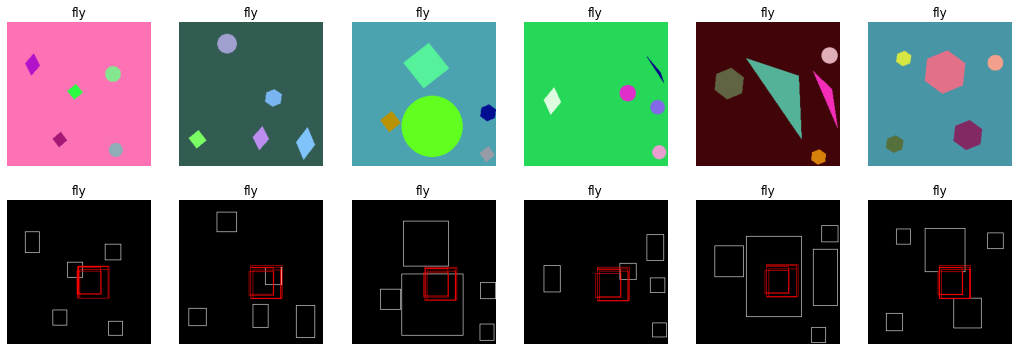

In [19]:
history = train_cnn(20, train_loader, batch_size=batch_size)

In [20]:
# torch.save(model.state_dict(), 'model_fly.pth')
torch.save(model.state_dict(), 'model_simple_fly.pth')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


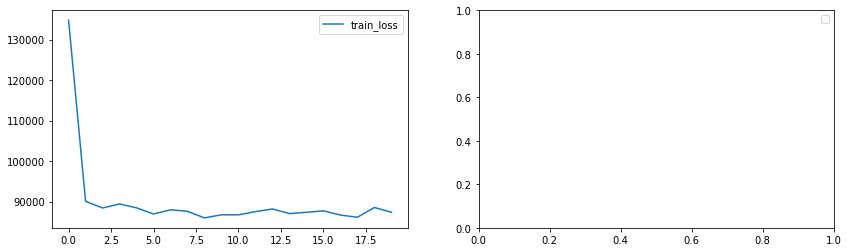

In [21]:
# plot(history['epoch'], history['train_loss'], label='train_loss')
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].plot(history['epoch'], history['train_loss'], label='train_loss')
# axes[0].plot(history['epoch'], history['val_loss'], label='val_loss')
# axes[1].plot(history['epoch'], history['val_score'], label='val_score')
for i in [0,1]:
    axes[i].legend()

In [22]:
torch.cuda.empty_cache()
gc.collect()

30582

In [23]:
# model = UNet().to(device)
model = ShapeDetector().to(device)

In [24]:
# model.load_state_dict(torch.load('model_fly.pth', map_location=torch.device(device)))
model.load_state_dict(torch.load('model_simple_fly.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [25]:
# iou, iou_mean, iou_min, iou_max, precision, recall = eval_cnn(test_1_loader, batch_size=8)
eval_output = eval_cnn(test_1_loader, batch_size=32)

In [26]:
print('precision:', eval_output[0], 'recall:', eval_output[1])

precision: 0.024844720496894408 recall: 0.004166666666666667


In [27]:
print('iou_min:', eval_output[8], 'iou_max:', eval_output[9])

iou_min: 0.0 iou_max: 0.6031215684495018


In [28]:
print('iou_mean:', np.mean(eval_output[10]))

iou_mean: 0.5800979677045411


In [29]:
results = pd.DataFrame (
    {
        'test':['test_1'],\
        'precision':[eval_output[0]], 'recall':[eval_output[1]],\
        'iou_min':[eval_output[8]], 'iou_max':[eval_output[9]],\
        'iou_mean':[np.mean(eval_output[10])],
        'triangle':['1003'],
        'square':['988'],
        'rhombus':['996'],
        'hexagon':['1023'],
        'circle':['990'],
        'total figures':['5000']
    }
)
results

,test,precision,recall,iou_min,iou_max,iou_mean,triangle,square,rhombus,hexagon,circle,total figures
0,test_1,0.024845,0.004167,0.0,0.603122,0.580098,1003,988,996,1023,990,5000


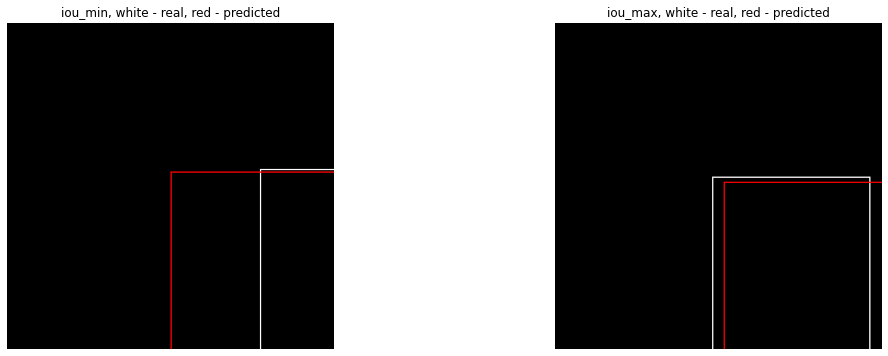

In [30]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(np.rollaxis(eval_output[6].numpy(), 0, 3))
# plt.title('real')
plt.subplot(1, 2, 1)
plt.axis("off")
image = Image.new("RGB", (256, 256))
draw = ImageDraw.Draw(image)
shapes = np.array(eval_output[2])
#     for j in range(5):
x1, y1 = shapes[0], shapes[1]
x2, y2 = x1 + shapes[2], y1 + shapes[3]
draw.polygon([(x1 ,y1), (x1, y2), (x2, y2), (x2, y1)], outline='white')
#         shapes = outputs[i].detach().numpy()
shapes = np.array(eval_output[3])
#     for j in range(5):
x1, y1 = shapes[0], shapes[1]
x2, y2 = x1 + shapes[2], y1 + shapes[3]
draw.polygon([(x1 ,y1), (x2, y1), (x2, y2), (x1, y2)], outline='red')
plt.imshow(image)
plt.title('iou_min, white - real, red - predicted')

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(np.rollaxis(eval_output[6].numpy(), 0, 3))
# plt.title('real')
plt.subplot(1, 2, 2)
plt.axis("off")
image = Image.new("RGB", (256, 256))
draw = ImageDraw.Draw(image)
shapes = np.array(eval_output[4])
#     for j in range(5):
x1, y1 = shapes[0], shapes[1]
x2, y2 = x1 + shapes[2], y1 + shapes[5]
draw.polygon([(x1 ,y1), (x1, y2), (x2, y2), (x2, y1)], outline='white')
#         shapes = outputs[i].detach().numpy()
shapes = np.array(eval_output[5])
#     for j in range(5):
x1, y1 = shapes[0], shapes[1]
x2, y2 = x1 + shapes[2], y1 + shapes[3]
draw.polygon([(x1 ,y1), (x2, y1), (x2, y2), (x1, y2)], outline='red')
plt.imshow(image)
plt.title('iou_max, white - real, red - predicted')

plt.show()

In [31]:
drawer.generate_images(5000, 'output', update = False)

In [32]:
train_data = My_Dataset(fly=False, folder = 'output')

Количество файлов : 5000
Количество файлов : 5000


In [33]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [34]:
torch.cuda.empty_cache()
gc.collect()

6351

In [35]:
# model = UNet().to(device)
model = ShapeDetector().to(device)

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 20 loss: 96.995
Количество triangle в эпохе обучения: 5000
Количество hexagon в эпохе обучения: 5029
Количество rhombus в эпохе обучения: 4951
Количество square в эпохе обучения: 4988
Количество circle в эпохе обучения: 5032
Количество фигур в эпохе обучения: 25000


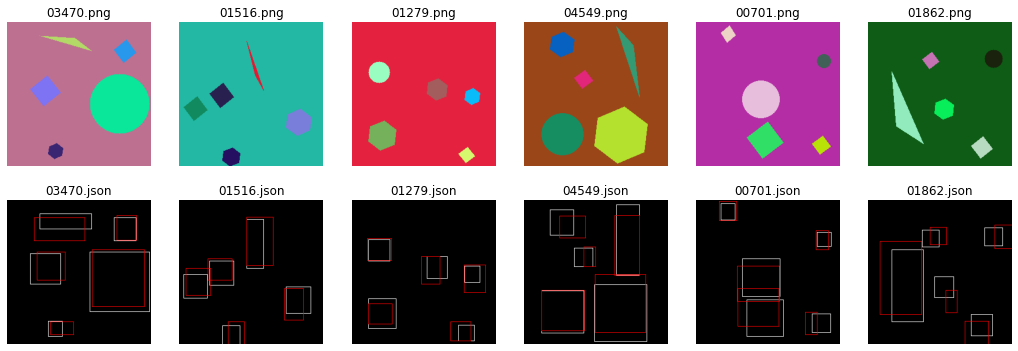

In [37]:
history = train_cnn(20, train_loader, batch_size=batch_size)

In [38]:
torch.save(model.state_dict(), 'model_simple_static.pth')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


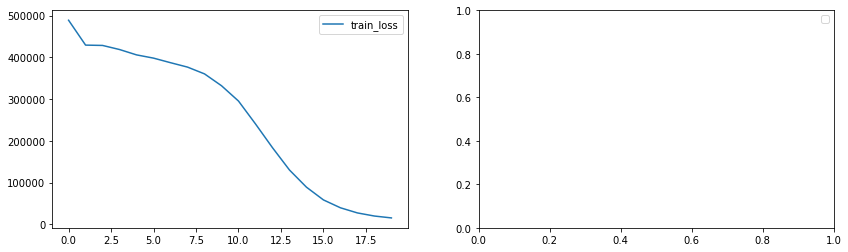

In [39]:
# plot(history['epoch'], history['train_loss'], label='train_loss')
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].plot(history['epoch'], history['train_loss'], label='train_loss')
# axes[0].plot(history['epoch'], history['val_loss'], label='val_loss')
# axes[1].plot(history['epoch'], history['val_score'], label='val_score')
for i in [0,1]:
    axes[i].legend()

In [40]:
torch.cuda.empty_cache()
gc.collect()

36326

In [41]:
# model = UNet().to(device)
model = ShapeDetector().to(device)

In [42]:
# model.load_state_dict(torch.load('model_fly.pth', map_location=torch.device(device)))
model.load_state_dict(torch.load('model_simple_static.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [43]:
# iou, iou_mean, iou_min, iou_max, precision, recall = eval_cnn(test_1_loader, batch_size=8)
eval_output = eval_cnn(test_2_loader, batch_size=32)

In [44]:
print('precision:', eval_output[0], 'recall:', eval_output[1])

precision: 0.017341040462427744 recall: 0.003125


In [45]:
print('iou_min:', eval_output[8], 'iou_max:', eval_output[9])

iou_min: 0.0 iou_max: 0.5293659010690289


In [46]:
print('iou_mean:', np.mean(eval_output[10]))

iou_mean: 0.5195406666713875


In [47]:
results = results.append (
    {
        'test':'test_2',\
        'precision':eval_output[0], 'recall':eval_output[1],\
        'iou_min':eval_output[8], 'iou_max':eval_output[9],\
        'iou_mean':np.mean(eval_output[10]),
        'triangle':'5004',
        'square':'5075',
        'rhombus':'5022',
        'hexagon':'4955',
        'circle':'4944',
        'total figures':'25000'
    }, ignore_index=True
)
results

,test,precision,recall,iou_min,iou_max,iou_mean,triangle,square,rhombus,hexagon,circle,total figures
0,test_1,0.024845,0.004167,0.0,0.603122,0.580098,1003,988,996,1023,990,5000
1,test_2,0.017341,0.003125,0.0,0.529366,0.519541,5004,5075,5022,4955,4944,25000


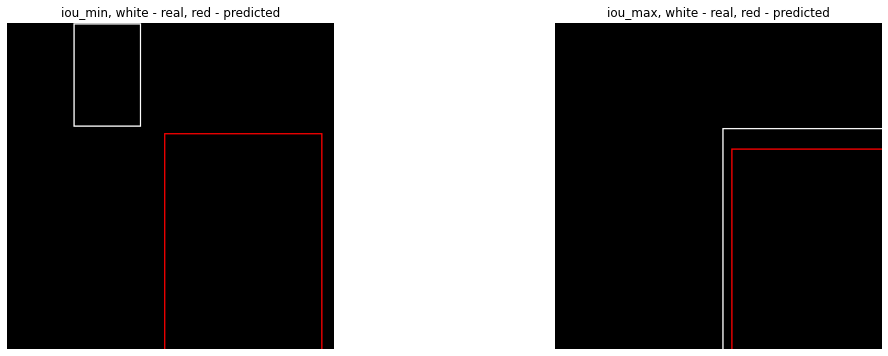

In [48]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(np.rollaxis(eval_output[6].numpy(), 0, 3))
# plt.title('real')
plt.subplot(1, 2, 1)
plt.axis("off")
image = Image.new("RGB", (256, 256))
draw = ImageDraw.Draw(image)
shapes = np.array(eval_output[2])
#     for j in range(5):
x1, y1 = shapes[0], shapes[1]
x2, y2 = x1 + shapes[2], y1 + shapes[3]
draw.polygon([(x1 ,y1), (x1, y2), (x2, y2), (x2, y1)], outline='white')
#         shapes = outputs[i].detach().numpy()
shapes = np.array(eval_output[3])
#     for j in range(5):
x1, y1 = shapes[0], shapes[1]
x2, y2 = x1 + shapes[2], y1 + shapes[3]
draw.polygon([(x1 ,y1), (x2, y1), (x2, y2), (x1, y2)], outline='red')
plt.imshow(image)
plt.title('iou_min, white - real, red - predicted')

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(np.rollaxis(eval_output[6].numpy(), 0, 3))
# plt.title('real')
plt.subplot(1, 2, 2)
plt.axis("off")
image = Image.new("RGB", (256, 256))
draw = ImageDraw.Draw(image)
shapes = np.array(eval_output[4])
#     for j in range(5):
x1, y1 = shapes[0], shapes[1]
x2, y2 = x1 + shapes[2], y1 + shapes[5]
draw.polygon([(x1 ,y1), (x1, y2), (x2, y2), (x2, y1)], outline='white')
#         shapes = outputs[i].detach().numpy()
shapes = np.array(eval_output[5])
#     for j in range(5):
x1, y1 = shapes[0], shapes[1]
x2, y2 = x1 + shapes[2], y1 + shapes[3]
draw.polygon([(x1 ,y1), (x2, y1), (x2, y2), (x1, y2)], outline='red')
plt.imshow(image)
plt.title('iou_max, white - real, red - predicted')

plt.show()

In [49]:
drawer = PictureDrawer(5, hexagon_status=False, random_status=False)
drawer.generate_images(12000, 'work', update = False)

In [50]:
drawer = PictureDrawer(5, hexagon_status=False, random_status=False)
drawer.generate_images(3000, 'work_test', update = False)

In [51]:
drawer = PictureDrawer(5, hexagon_status=True, random_status=False)
drawer.generate_images(3000, 'work_test_hexagon', update = False)

In [52]:
test_1_data = My_Dataset(folder = 'work_test', fly=False)
test_2_data = My_Dataset(folder = 'work_test_hexagon', fly=False)

Количество файлов : 3000
Количество файлов : 3000
Количество файлов : 3000
Количество файлов : 3000


In [53]:
test_1_loader = torch.utils.data.DataLoader(test_1_data, batch_size=batch_size, shuffle=False)
test_2_loader = torch.utils.data.DataLoader(test_2_data, batch_size=batch_size, shuffle=False)

In [54]:
torch.cuda.empty_cache()
gc.collect()

7796

In [55]:
train_data = My_Dataset(fly=False, folder='work')

Количество файлов : 12000
Количество файлов : 12000


In [56]:
test_1_data = My_Dataset(folder = 'work_test', fly=False)

Количество файлов : 3000
Количество файлов : 3000


In [57]:
test_2_data = My_Dataset(folder = 'work_test_hexagon', fly=False)

Количество файлов : 3000
Количество файлов : 3000


In [58]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_1_loader = torch.utils.data.DataLoader(test_1_data, batch_size=batch_size, shuffle=False)
test_2_loader = torch.utils.data.DataLoader(test_2_data, batch_size=batch_size, shuffle=False)

In [59]:
# Define the neural network architecture
model = ShapeDetector().to(device)
# model = My_CNN().to(device)
# model = FigureDetector().to(device)
# model = UNet().to(device)

In [60]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 20 loss: 58.365
Количество triangle в эпохе обучения: 12000
Количество circle в эпохе обучения: 12000
Количество square в эпохе обучения: 12000
Количество rhombus в эпохе обучения: 24000
Количество фигур в эпохе обучения: 60000


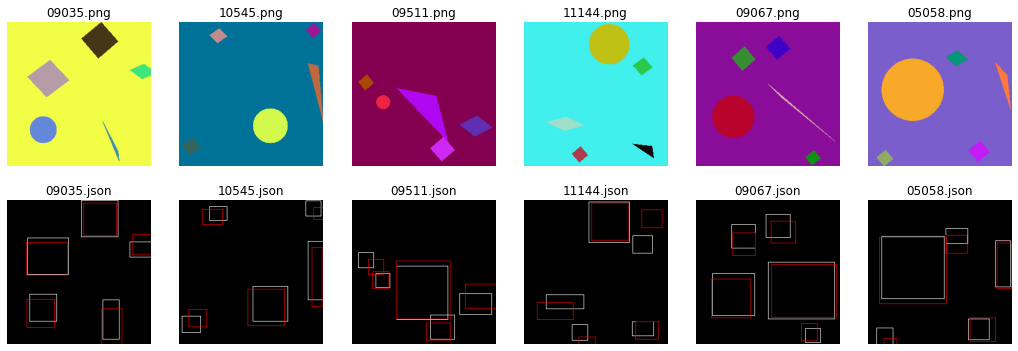

In [61]:
history = train_cnn(20, train_loader, batch_size=32)

In [62]:
torch.save(model.state_dict(), 'model_simple_start_learning.pth')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


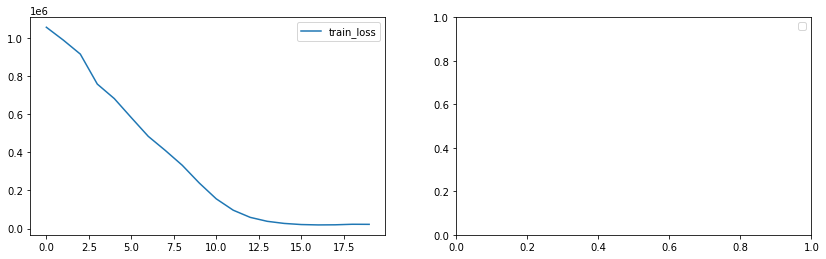

In [63]:
# plot(history['epoch'], history['train_loss'], label='train_loss')
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].plot(history['epoch'], history['train_loss'], label='train_loss')
# axes[0].plot(history['epoch'], history['val_loss'], label='val_loss')
# axes[1].plot(history['epoch'], history['val_score'], label='val_score')
for i in [0,1]:
    axes[i].legend()

Epoch 20 loss: 6.693
Количество triangle в эпохе обучения: 20000
Количество circle в эпохе обучения: 20000
Количество square в эпохе обучения: 20000
Количество rhombus в эпохе обучения: 32000
Количество hexagon в эпохе обучения: 8000
Количество фигур в эпохе обучения: 100000


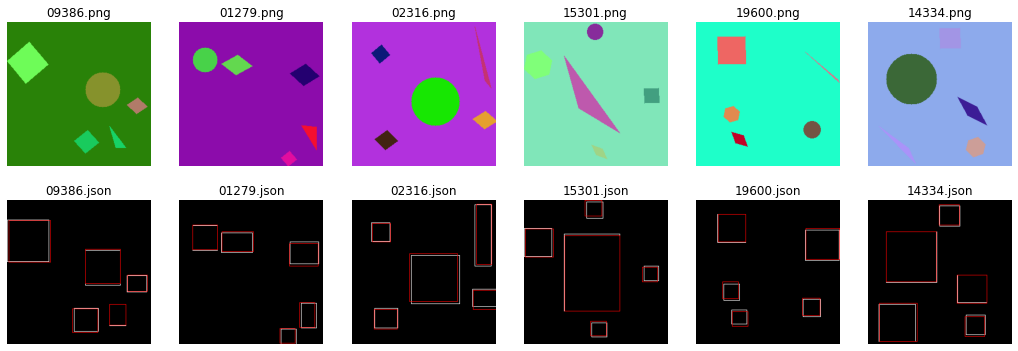

In [64]:
for i in range(20):
    drawer.generate_images(400, 'work', update = True)
    results = transfer_learning(i, 20, status=results)

In [65]:
results

,test,precision,recall,iou_min,iou_max,iou_mean,triangle,square,rhombus,hexagon,circle,total figures
0,test_1,0.024845,0.004167,0.0,0.603122,0.580098,1003,988,996,1023,990,5000
1,test_2,0.017341,0.003125,0.0,0.529366,0.519541,5004,5075,5022,4955,4944,25000
2,0_test,0.132588,0.029433,0.0,0.877790,0.614414,3000,3000,6000,0,3000,15000
3,0_test_hexagon,0.153578,0.031206,0.0,0.888092,0.618081,3000,3000,3000,3000,3000,15000
4,1_test,0.111908,0.027660,0.0,0.853802,0.613129,3000,3000,6000,0,3000,15000
5,1_test_hexagon,0.144201,0.032624,0.0,0.866891,0.613922,3000,3000,3000,3000,3000,15000
6,2_test,0.139860,0.035461,0.0,0.834772,0.606267,3000,3000,6000,0,3000,15000
7,2_test_hexagon,0.151786,0.036170,0.0,0.836780,0.617295,3000,3000,3000,3000,3000,15000
8,3_test,0.141892,0.037234,0.0,0.855254,0.598709,3000,3000,6000,0,3000,15000
9,3_test_hexagon,0.137931,0.036879,0.0,0.911874,0.616230,3000,3000,3000,3000,3000,15000


In [67]:
results.to_csv('results.csv')